# Brain Tumor Detection with SyMPC
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt


In [3]:
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
classes = os.listdir(data_dir)

In [8]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(100),             # resize shortest side to 100 pixels
        transforms.CenterCrop(100),         # crop longest side to 100 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [9]:
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 506


In [10]:
img, label = dataset[100]
print(img.shape)


torch.Size([3, 100, 100])


In [11]:
# function for the showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  brain_tumor_dataset (0)


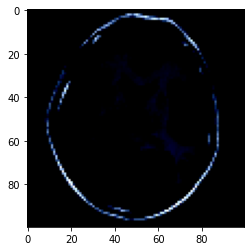

In [12]:
show_image(*dataset[50])

In [13]:
torch.manual_seed(20)
val_size = len(dataset)//10
test_size = len(dataset)//5
train_size = len(dataset) - val_size -test_size


In [14]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)


(355, 50, 101)

In [15]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


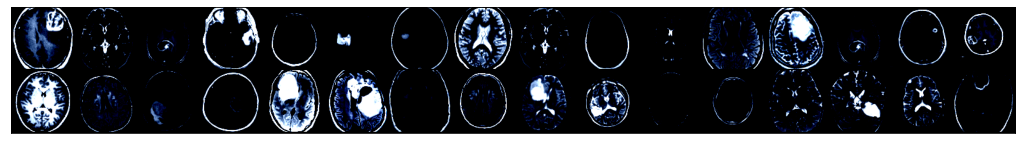

In [16]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

Model Evaluation

In [17]:
torch.cuda.is_available()


True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [19]:
device = get_default_device()
device


device(type='cuda')

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
input_size = 3*100*100
output_size = 3



Image Classification

In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


CNN model

In [22]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # block 1
        self.conv1 = nn.ReLU(nn.Conv2d(3, 100, kernel_size=3, padding=1))
        self.conv2 = nn.ReLU(nn.Conv2d(100, 150, kernel_size=3, padding=1, stride=1))
        self.maxpool1 = nn.MaxPool2d(2,2)

        # block 2
        self.conv3 = nn.ReLU(nn.Conv2d(150, 200, kernel_size=3, padding=1, stride=1))
        self.conv4 = nn.ReLU(nn.Conv2d(200, 200, kernel_size=3, padding=1, stride=1))
        self.maxpool2 = nn.MaxPool2d(2,2)

        # block 3
        self.conv5 = nn.ReLU(nn.Conv2d(200, 250, kernel_size=3, padding=1, stride=1))
        self.conv6 = nn.ReLU(nn.Conv2d(250, 250, kernel_size=3, padding=1, stride=1))
        self.maxpool3 = nn.MaxPool2d(2,2)

        self.flat = nn.Flatten()
        self.linear1 = nn.ReLU(nn.Linear(36000, 3600))
        self.linear2 = nn.ReLU(nn.Linear(3600, 600))
        self.linear3 = nn.ReLU(nn.Linear(600, 30))
        self.dropout = nn.Dropout()
        self.out = nn.Linear(30, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpool3(x)

        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.double(x)
        out = self.out(x)
        return out




    # self.network = nn.Sequential(
    #         nn.Conv2d(3, 100, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(2, 2), # output: 150 x 16 x 16
    #
    #         nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
    #         nn.ReLU(),
    #         nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(2, 2), # output: 200 x 8 x 8
    #
    #         nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
    #         nn.ReLU(),
    #         nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(2, 2), # output: 250 x 4 x 4
    #
    #         nn.Flatten(),
    #         nn.Linear(36000, 3600),
    #         nn.ReLU(),
    #         nn.Linear(3600, 600),
    #         nn.ReLU(),
    #         nn.Linear(600, 30),
    #         nn.ReLU(),
    #         nn.Dropout(0.25),
    #         nn.Linear(30, 3))
    #
    # def forward(self, xb):
    #     return self.network(xb)


In [23]:
model = CnnModel()


In [24]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)


CnnModel(
  (conv1): ReLU(
    inplace=True
    (inplace): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): ReLU(
    inplace=True
    (inplace): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): ReLU(
    inplace=True
    (inplace): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): ReLU(
    inplace=True
    (inplace): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): ReLU(
    inplace=True
    (inplace): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv6): ReLU(
    inplace=True
    (inplace): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
model = to_device(CnnModel(), device)


In [27]:
history=[evaluate(model, val_loader)]
history

TypeError: double() takes 1 positional argument but 2 were given

In [29]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
torch.cuda.memory_summary(device=device, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1025 MB |    1030 MB |    1031 MB |    5852 KB |\n|       from large pool |    1024 MB |    1028 MB |    1028 MB |    4584 KB |\n|       from small pool |       1 MB |       2 MB |       2 MB |    1268 KB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1025 MB |    1030 MB |    1031 MB |    5852 KB |\n|       from large pool |    1024 MB |    1028 MB |

In [31]:
torch.cuda.empty_cache()
history = []
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


RuntimeError: DataLoader worker (pid(s) 10344, 3288, 10500, 16148) exited unexpectedly

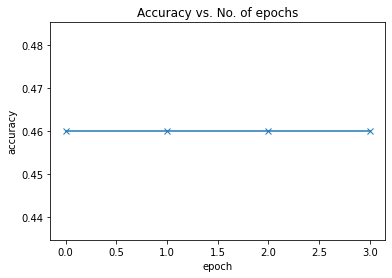

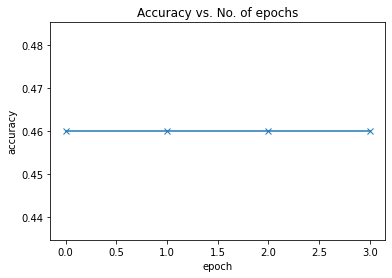

{'val_loss': 1.038857340812683, 'val_acc': 0.4653465449810028}

In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()
plot_accuracies(history)
plot_accuracies(history)
evaluate(model, test_loader)